In [37]:
import sys
sys.dont_write_bytecode = True

import numpy as np
import pandas as pd
from datetime import date
import graphviz
import gurobipy as gp
from gurobipy import GRB
sys.path.append("simulator")
from simulator import simulator as sim
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr
import matplotlib.pyplot as plt

random.seed(1234)

def trunc(temp): # utility function for node naming
    st = temp.find("(")
    temp = temp[:st]
    return temp

sim.three_depth_application()

User capacity: 99999999
A capacity: 33.333333333333336
B capacity: 100.0
C capacity: 40.0
D capacity: 25.0
E capacity: 33.333333333333336
F capacity: 100.0
- num_replica_for_cluster_0
	- User: 1
	- A: 2
	- B: 2
	- C: 2
	- D: 2
	- E: 2
	- F: 2
- num_replica_for_cluster_1
	- User: 1
	- A: 2
	- B: 2
	- C: 2
	- D: 2
	- E: 2
	- F: 2
===== print_service_and_replica =====
User
	cluster 0 User_0(node[0000])
	cluster 1 User_1(node[1000])
A
	cluster 0 A_0(node[0000])
	cluster 0 A_2(node[0000])
	cluster 1 A_1(node[1000])
	cluster 1 A_3(node[1000])
B
	cluster 0 B_0(node[0000])
	cluster 0 B_2(node[0000])
	cluster 1 B_1(node[1000])
	cluster 1 B_3(node[1000])
C
	cluster 0 C_0(node[0000])
	cluster 0 C_2(node[0000])
	cluster 1 C_1(node[1000])
	cluster 1 C_3(node[1000])
D
	cluster 0 D_0(node[0000])
	cluster 0 D_2(node[0000])
	cluster 1 D_1(node[1000])
	cluster 1 D_3(node[1000])
E
	cluster 0 E_0(node[0000])
	cluster 0 E_2(node[0000])
	cluster 1 E_1(node[1000])
	cluster 1 E_3(node[1000])
F
	cluster 0 F_0(

(<simulator.simulator.Replica at 0x7f7ac9a9e760>,
 <simulator.simulator.Service at 0x7f7ae8a80160>)

## Predict the Service times

We will utilize a simple prediction model to estimate the service time for each individual service. This estimation will be based on inputs such as requests per second and CPU utilization. Service times of each service have their own unique relationship with requests per second, cpu utilization and other variables. The model assumes that the required telemetry inputs are collected from multiple clusters and grouped by service and cluster for model fitting and prediction. 
All variables in this model are server-side not client-side.

Model
- Linear regression or polynomial regression

Input
- $service\ name$: name of a service
- $cluster\ id$: uid of a cluster
- $rps$ : request per second
- $cpu$: cpu utilization of pod
- $mem$ : memory utilization of pod

Output
- $service\ time$: from the time that a request arrives at service A to the time that a request leaves service A.
    - service time includes service execution time and queueing 
    - This model assumes that service time can be predicted by request per second, cpu utilization and memory utilization.

This model has nothing to do with communication between services or network latency.

Note that terms like 'service time,' 'compute time,' and 'compute latency' are all used interchangeably.

<!-- ### Current model
- Assumption
  - The prediction model is polynomial regressor with the degree of 2.
  - Each service has 100 data point to be used for model fitting. -->


## Problem formulation
- Application will be represented in a form of graph.

- Node
  - Format: "$\{service\ name\}\_\{replica\ id\}\_\{start/end\}$
  - Start node
    - the time that a request arrives at service A
    - e.g.: A_0_start, B_0_start
  - End node
    - the time that a request leaves service A
    - e.g.: A_0_end, B_0_end
  - 
    - compute time
      - start_node - end_node
        - e.g.: A_0_start - A_0_end, B_1_start - B_1_end
      - end_node - start_node
        - e.g.: A_0_end - B_0_start, A_0_end - B_1_start

- Edge
  - Edges represents either compute time of a service or network latency between replicas.
  - Compute edge
    - Service time (compute time)
    - This is the one that will be predicted by the above prediction model.
    - [start_node]--[end_node]
      - e.g.: A_0_start - A_0_end, B_1_start - B_1_end
  - Network edge
    - Network latecny
    - [end_node]--[start_node]
      - e.g.: A_0_end - B_0_start, A_0_end - B_1_start

- Latency = (compute time or network latency) * (number of requests that flows through the edge)

- Objective
  - Minimize the sum of all latency
  - <-> Minimize average latency for a batch of requests. 
  - Note that it is not identical with balancing loads between clusters.

<compute_time_observation df>


,service_name,rps,cpu,mem,compute_time
"(A_0_start, A_0_end)",A,0,0,0,1932.907071
"(A_0_start, A_0_end)",A,1,1,1,882.465198
"(A_0_start, A_0_end)",A,2,2,2,18.982940
"(A_0_start, A_0_end)",A,3,3,3,1830.951925
"(A_0_start, A_0_end)",A,4,4,4,1894.537995
...,...,...,...,...,...
"(F_3_start, F_3_end)",F,95,95,95,10671.249719
"(F_3_start, F_3_end)",F,96,96,96,10264.388419
"(F_3_start, F_3_end)",F,97,97,97,10454.213153
"(F_3_start, F_3_end)",F,98,98,98,9619.340600


The R^2 value in the test set is 0.96601


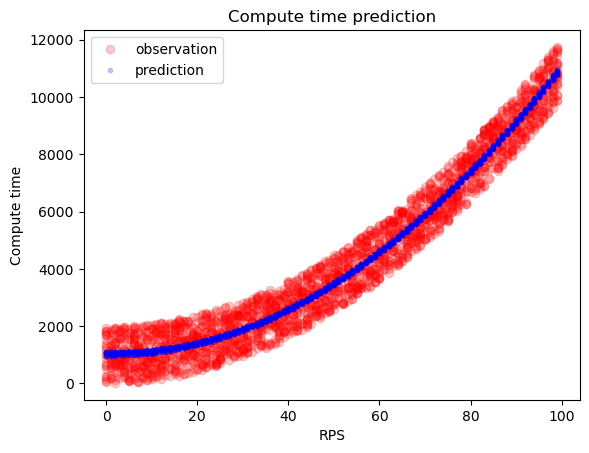

In [2]:
true_function_degree = 2
regressor_degree = 2
num_data_point = 100 # fake observation data point per service
randomize_factor = 2000
x_rps = list()
x_cpu = list()
x_service_name = list()
y_compute_time = list()
svc_name_list = list()

compute_arc_var_name = list()
for repl in sim.dag.all_replica:
    if repl.service.name != "User":
        var_name = (trunc(repl.to_str())+"_start", trunc(repl.to_str())+"_end")
        compute_arc_var_name.append(var_name)
        svc_name_list.append(repl.service.name)

network_arc_var_name = list()
for parent_repl in sim.dag.child_replica:
    for child_svc in sim.dag.child_replica[parent_repl]:
        child_repl_list = sim.dag.child_replica[parent_repl][child_svc]
        for child_repl in child_repl_list:
            if parent_repl.service.name == "User":
                var_name = ("src_*_*", trunc(child_repl.to_str())+"_start")
                if var_name not in network_arc_var_name:
                    network_arc_var_name.append(var_name)
            else:
                var_name = (trunc(parent_repl.to_str())+"_end",  trunc(child_repl.to_str())+"_start")
                if var_name not in network_arc_var_name:
                    network_arc_var_name.append(var_name)
            if sim.dag.is_leaf(child_repl.service):
                var_name = (trunc(child_repl.to_str())+"_end", "dst_*_*")
                if var_name not in network_arc_var_name:
                    network_arc_var_name.append(var_name)

other_arc_var_name = list()
for repl in sim.dag.all_replica:
    if sim.dag.is_leaf(repl.service):
        other_arc_var_name.append(trunc(repl.to_str())+"_end" + "_" + "dst_*_*")

total_var_name = compute_arc_var_name + network_arc_var_name + other_arc_var_name
x_repl_name = list()
for i in range(len(compute_arc_var_name)):
    x_rps += list(np.arange(0,num_data_point))
    x_cpu += list(np.arange(0,num_data_point))
    x_repl_name += [compute_arc_var_name[i]] * num_data_point
    x_service_name += svc_name_list[i] * num_data_point

for _ in compute_arc_var_name:
    for i in range(num_data_point):
        y_compute_time.append(pow(x_rps[i],true_function_degree) + random.random()*randomize_factor)
        # y_compute_time.append(pow(x_rps[i],true_function_degree) + x_cpu[i] + random.random()*randomize_factor)

## Debug print
# for v in network_arc_var_name:
#     print(v)
# print("compute_arc_var: ", len(compute_arc_var_name))
# print("network_arc_var: ", len(network_arc_var_name))
# print("other_arc_var_name: ", len(other_arc_var_name))
# print("total_arc_var: ", len(compute_arc_var_name) + len(network_arc_var_name) + len(other_arc_var_name))

# print("x_service_name")
# print(x_service_name)

# print(len(x_rps))
# print(len(x_cpu))
# print(len(x_repl_name))
# print(len(x_service_name))
# print(len(y_compute_time))

compute_time_observation = pd.DataFrame(
    data={
        "service_name": x_service_name,
        "rps": x_rps, 
        "cpu": x_cpu, 
        "mem": x_cpu, 
        "compute_time": y_compute_time,
    },
    index=x_repl_name
)

# with pd.option_context('display.max_rows', None,):
#     with pd.option_context('display.max_colwidth', None):
#         display(compute_time_observation)
print("<compute_time_observation df>")
display(compute_time_observation)

X = compute_time_observation[["service_name", "rps", "cpu", "mem"]]
# X = compute_time_observation[["service_name", "rps", "cpu"]]
# X = compute_time_observation[["service_name", "rps"]]
y = compute_time_observation["compute_time"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)

    # (StandardScaler(), ["rps", "cpu"]),
    # ("passthrough", ["rps"]),
    
feat_transform = make_column_transformer(
    (OneHotEncoder(), ["service_name"]),
    (StandardScaler(), ["rps", "cpu", "mem"]),
    verbose_feature_names_out=False,
    remainder='drop'
)

## Pipeline consists of
## 1. trasformation of input feature
## 2. training the model using X_train, y_train dataset
if regressor_degree == 1:
    reg = make_pipeline(feat_transform, LinearRegression())
    reg.fit(X_train, y_train)
elif regressor_degree > 1:
    poly = PolynomialFeatures(degree=regressor_degree, include_bias=True)
    reg = make_pipeline(feat_transform, poly, LinearRegression())
    reg.fit(X_train, y_train)
    #################################################
    ## Break down polynomial regressor pipeline ##
    #################################################
    # print("Original X_train: ", X_train)
    # X_train_T = feat_transform.fit_transform(X_train)
    # print("X_train_T: ", X_train_T)
    # poly = PolynomialFeatures(degree=regressor_degree, include_bias=True)
    # X_train_poly = poly.fit_transform(X_train_T)
    # print("X_train_poly: ", X_train_poly)
    # reg = LinearRegression()
    # reg.fit(X_train_poly, y_train)
    # print("poly.get_feature_names_out(): ", poly.get_feature_names_out())

## Debug print
# print(reg[0])
# print(reg[1])
# print(reg)

## Print trained parameters(coefficients) of the model
# print("Coefficients of linear regression model: ", reg["linearregression"].coef_)

## Run prediction and compare it with the ground truth to see how accurate the trained model is
y_pred = reg.predict(X_test)
print(f"The R^2 value in the test set is {np.round(r2_score(y_test, y_pred),5)}")
plt.plot(X["rps"], y, 'ro', label="observation", alpha=0.2)
plt.plot(X["rps"], reg.predict(X), 'b.', label="prediction", alpha=0.2)
plt.legend()
plt.title("Compute time prediction")
plt.xlabel("RPS")
plt.ylabel("Compute time")
plt.show()

In [130]:
# ## Debug print
# ## Output of the Column transformer
# temp = feat_transform.fit_transform(X_train)
# display(pd.DataFrame(temp))

## Optimize latency for num of requests
Notation for the formulation of the mathematical optimization model.

### Decision Variables
A decision variable stands for an unknown variable in an optimization problem.

src and dst in $X^{dst}_{src}$ notation is a edge from src node to dst node.

- $rps^{dst}_{src}$: number of request that flows from src to dst

- $compute\ time^{dst}_{src}$: compute time between $src$ and $dst$ in gurobi $arcs$ variable. 
  - It is **constrainted** by the above prediction model.
  - $compute\ time = model(r, c, m, s)$: predicted service time of service $s$ when rps, cpu util and memory util are $r$, $c$ and $m$ respectively.

- $network\ latency^{dst}_{src}$: network latency between $src$ and $dst$ in gurobi $arcs$ variable. 
  - It is fixed value.
  - Should it be RTT or one-way latency?
  - 
### lower/upper bound for decision variables
- $r^s_{min}$: minimum rps for service $s$
- $r^s_{max}$: maximum rps for service $s$
- $c^s_{min}$: minimum cpu util for service $s$
- $c^s_{max}$: maximum cpu util for service $s$
- $m^s_{min}$: minimum memory util for service $s$
- $m^s_{max}$: maximum memory util for service $s$

### Defining variables using Gurobi pandas

The main purpose of compute_time_data and network_arc_var_name dataframe is to define the gurobi variable later.

In [3]:
min_cpu = 0
max_cpu = 100
min_mem = 0
max_mem = 100
min_rps = 0
max_rps = GRB.INFINITY

min_compute_time = [0] * len(compute_arc_var_name)
max_compute_time = [GRB.INFINITY] * len(compute_arc_var_name) # SLO
compute_time_data = pd.DataFrame(
    data={
        # "service_name":compute_arc_var_name,
        "min_cpu":[min_cpu]*len(compute_arc_var_name),
        "max_cpu":[max_cpu]*len(compute_arc_var_name),
        "min_mem":[min_mem]*len(compute_arc_var_name),
        "max_mem":[max_mem]*len(compute_arc_var_name),
        "min_rps":[min_rps]*len(compute_arc_var_name),
        "max_rps":[max_rps]*len(compute_arc_var_name),
        "min_compute_time": min_compute_time,
        "max_compute_time": max_compute_time,
    },
    index=compute_arc_var_name
)

min_network_latency = list()
max_network_latency = list()
for src_repl, dst_repl in network_arc_var_name:
    # print("src_repl: ", src_repl)
    # print("dst_repl: ", dst_repl)
    src_svc = src_repl.split("_")[0]
    dst_svc = dst_repl.split("_")[0]
    if src_svc == "src":
        min_network_latency.append(0)
        max_network_latency.append(0)
    elif dst_svc == "dst":
        min_network_latency.append(0)
        max_network_latency.append(0)
    else:
        from_idx = int(src_repl.split("_")[1])
        to_idx = int(dst_repl.split("_")[1])
        # Network latency for local routing
        if from_idx%2 == to_idx%2:
            min_network_latency.append(sim.NetworkLatency().same_rack)
            max_network_latency.append(sim.NetworkLatency().same_rack)
        # Network latency for remote routing
        else:
            min_network_latency.append(sim.NetworkLatency().far_inter_region)
            max_network_latency.append(sim.NetworkLatency().far_inter_region)

network_latency_data = pd.DataFrame(
    data={
        # "service_name":network_arc_var_name,
        "min_rps":[min_rps]*len(network_arc_var_name),
        "max_rps":[max_rps]*len(network_arc_var_name),
        "min_network_latency": min_network_latency,
        "max_network_latency": max_network_latency,
    },
    index=network_arc_var_name
)


# with pd.option_context('display.max_rows', None,):
#     with pd.option_context('display.max_colwidth', None):
# print("compute_time_data")
# display(compute_time_data)
print("network_latency_data")
display(network_latency_data)

network_latency_data


,min_rps,max_rps,min_network_latency,max_network_latency
"(src_*_*, A_0_start)",0,1.000000e+100,0.0,0.0
"(src_*_*, A_2_start)",0,1.000000e+100,0.0,0.0
"(src_*_*, A_1_start)",0,1.000000e+100,0.0,0.0
"(src_*_*, A_3_start)",0,1.000000e+100,0.0,0.0
"(A_0_end, B_0_start)",0,1.000000e+100,0.5,0.5
...,...,...,...,...
"(D_3_end, E_3_start)",0,1.000000e+100,0.5,0.5
"(D_3_end, F_0_start)",0,1.000000e+100,30.0,30.0
"(D_3_end, F_2_start)",0,1.000000e+100,30.0,30.0
"(D_3_end, F_1_start)",0,1.000000e+100,0.5,0.5


### gppd.add_vars

gppd.add_vars will add multiple new variables to the model. These variables will have the same name of the index given as a second argument in add_vars method. It returns pandas Series object which is composed of a list of gurobi variables with index.

The second argument of gppd.add_vars method is "pandas_obj" – A pandas Index, Series, or DataFrame.

In [4]:
model = gp.Model('RequestRouting')

# Add variables for the regression
compute_time = gppd.add_vars(model, compute_time_data, name="compute_time", lb="min_compute_time", ub="max_compute_time")

cpu = gppd.add_vars(model, compute_time_data, name="cpu", lb="min_cpu", ub="max_cpu")

mem = gppd.add_vars(model, compute_time_data, name="mem", lb="min_mem", ub="max_mem")

compute_rps = gppd.add_vars(model, compute_time_data, name="rps_for_compute_edge", lb="min_rps", ub="max_rps")
model.update()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-13


### gurobi_ml.add_predictor_constr

gurobi_ml.add_predictor_constr simply adds constraint to the model. What makes add_predictor_constr different from normal addConstr(s) is whether the constraint is in the form of ml model or not.

In this example, we utilize linear/poly regressor model to predict compute time. The variables representing compute time is "compute time" which is y value of the model. We already train the regressor model which has "service_name", "rps", "cpu", "mem" as column name of input features and "compute_time" as column name of y value in dataframe.

"m_feats" is dataframe object and this dataframe **must** have the same index as "compute time" gurobi variable to be used in add_predictor. The index of "compute time" is compute_arc_var_name ("tuple(start_node, end_node)" of the same service as defined earlier). The index of m_feats is "compute_arc_var_name" which is basically same as the index of "compute time" variable.
"m_feats" will be fed into the constraint as input variable of the model. "compute time" is the output variable of the model.

reference: https://gurobi-machinelearning.readthedocs.io/en/stable/api/AbstractPredictorConstr.html

In [5]:
m_feats = pd.DataFrame(
    data={
        # "service_name": compute_arc_var_name,
        "service_name": svc_name_list,
        "rps": compute_rps,
        "cpu": cpu,
        "mem": mem,
    },
    index=compute_arc_var_name
)
print("m_feats")
display(m_feats)
print("compute_time")
print(type(compute_time))
display(compute_time)
pred_constr = add_predictor_constr(model, reg, m_feats, compute_time)
pred_constr.print_stats()
model.update()

m_feats


,service_name,rps,cpu,mem
"(A_0_start, A_0_end)",A,"<gurobi.Var rps_for_compute_edge[('A_0_start',...","<gurobi.Var cpu[('A_0_start',_'A_0_end')]>","<gurobi.Var mem[('A_0_start',_'A_0_end')]>"
"(A_2_start, A_2_end)",A,"<gurobi.Var rps_for_compute_edge[('A_2_start',...","<gurobi.Var cpu[('A_2_start',_'A_2_end')]>","<gurobi.Var mem[('A_2_start',_'A_2_end')]>"
"(B_0_start, B_0_end)",B,"<gurobi.Var rps_for_compute_edge[('B_0_start',...","<gurobi.Var cpu[('B_0_start',_'B_0_end')]>","<gurobi.Var mem[('B_0_start',_'B_0_end')]>"
"(B_2_start, B_2_end)",B,"<gurobi.Var rps_for_compute_edge[('B_2_start',...","<gurobi.Var cpu[('B_2_start',_'B_2_end')]>","<gurobi.Var mem[('B_2_start',_'B_2_end')]>"
"(C_0_start, C_0_end)",C,"<gurobi.Var rps_for_compute_edge[('C_0_start',...","<gurobi.Var cpu[('C_0_start',_'C_0_end')]>","<gurobi.Var mem[('C_0_start',_'C_0_end')]>"
"(C_2_start, C_2_end)",C,"<gurobi.Var rps_for_compute_edge[('C_2_start',...","<gurobi.Var cpu[('C_2_start',_'C_2_end')]>","<gurobi.Var mem[('C_2_start',_'C_2_end')]>"
"(D_0_start, D_0_end)",D,"<gurobi.Var rps_for_compute_edge[('D_0_start',...","<gurobi.Var cpu[('D_0_start',_'D_0_end')]>","<gurobi.Var mem[('D_0_start',_'D_0_end')]>"
"(D_2_start, D_2_end)",D,"<gurobi.Var rps_for_compute_edge[('D_2_start',...","<gurobi.Var cpu[('D_2_start',_'D_2_end')]>","<gurobi.Var mem[('D_2_start',_'D_2_end')]>"
"(E_0_start, E_0_end)",E,"<gurobi.Var rps_for_compute_edge[('E_0_start',...","<gurobi.Var cpu[('E_0_start',_'E_0_end')]>","<gurobi.Var mem[('E_0_start',_'E_0_end')]>"
"(E_2_start, E_2_end)",E,"<gurobi.Var rps_for_compute_edge[('E_2_start',...","<gurobi.Var cpu[('E_2_start',_'E_2_end')]>","<gurobi.Var mem[('E_2_start',_'E_2_end')]>"


compute_time
<class 'pandas.core.series.Series'>


(A_0_start, A_0_end)    <gurobi.Var compute_time[('A_0_start',_'A_0_en...
(A_2_start, A_2_end)    <gurobi.Var compute_time[('A_2_start',_'A_2_en...
(B_0_start, B_0_end)    <gurobi.Var compute_time[('B_0_start',_'B_0_en...
(B_2_start, B_2_end)    <gurobi.Var compute_time[('B_2_start',_'B_2_en...
(C_0_start, C_0_end)    <gurobi.Var compute_time[('C_0_start',_'C_0_en...
(C_2_start, C_2_end)    <gurobi.Var compute_time[('C_2_start',_'C_2_en...
(D_0_start, D_0_end)    <gurobi.Var compute_time[('D_0_start',_'D_0_en...
(D_2_start, D_2_end)    <gurobi.Var compute_time[('D_2_start',_'D_2_en...
(E_0_start, E_0_end)    <gurobi.Var compute_time[('E_0_start',_'E_0_en...
(E_2_start, E_2_end)    <gurobi.Var compute_time[('E_2_start',_'E_2_en...
(F_0_start, F_0_end)    <gurobi.Var compute_time[('F_0_start',_'F_0_en...
(F_2_start, F_2_end)    <gurobi.Var compute_time[('F_2_start',_'F_2_en...
(A_1_start, A_1_end)    <gurobi.Var compute_time[('A_1_start',_'A_1_en...
(A_3_start, A_3_end)    <gurobi.Var co

Model for pipe:
1536 variables
96 constraints
1320 quadratic constraints
Input has shape (24, 4)
Output has shape (24, 1)

Pipeline has 3 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
col_trans            (24, 9)           72           72            0            0

poly_feat           (24, 55)         1464            0         1320            0

lin_reg              (24, 1)            0           24            0            0

--------------------------------------------------------------------------------


In [6]:
network_latency = gppd.add_vars(model, network_latency_data, name="network_latency", lb="min_network_latency", ub="max_network_latency")

network_rps = gppd.add_vars(model, network_latency_data, name="rps_for_network_edge", lb="min_rps", ub="max_rps")

model.update()

print(type(network_latency))
print(network_latency)
print(network_rps)

<class 'pandas.core.series.Series'>
(src_*_*, A_0_start)    <gurobi.Var network_latency[('src____',_'A_0_s...
(src_*_*, A_2_start)    <gurobi.Var network_latency[('src____',_'A_2_s...
(src_*_*, A_1_start)    <gurobi.Var network_latency[('src____',_'A_1_s...
(src_*_*, A_3_start)    <gurobi.Var network_latency[('src____',_'A_3_s...
(A_0_end, B_0_start)    <gurobi.Var network_latency[('A_0_end',_'B_0_s...
                                              ...                        
(D_3_end, E_3_start)    <gurobi.Var network_latency[('D_3_end',_'E_3_s...
(D_3_end, F_0_start)    <gurobi.Var network_latency[('D_3_end',_'F_0_s...
(D_3_end, F_2_start)    <gurobi.Var network_latency[('D_3_end',_'F_2_s...
(D_3_end, F_1_start)    <gurobi.Var network_latency[('D_3_end',_'F_1_s...
(D_3_end, F_3_start)    <gurobi.Var network_latency[('D_3_end',_'F_3_s...
Name: network_latency, Length: 100, dtype: object
(src_*_*, A_0_start)    <gurobi.Var rps_for_network_edge[('src____',_'...
(src_*_*, A_2_start)    <g

In [7]:
# print("="*30 + " var: service time " + "="*30)
# print(compute_time)
# print("="*30 + " var: rps " + "="*30)
# print(rps)
# print("="*30 + " var: network latency " + "="*30)
# print(network_latency)

## Print all gurobi variables 
print("="*30 + " model object " + "="*30)
print("len(model.getVars()): ", len(model.getVars()))
model_vars = model.getVars()
for v in model_vars:
    print(v)

============================== model object ==============================
len(model.getVars()):  1832
<gurobi.Var compute_time[('A_0_start',_'A_0_end')]>
<gurobi.Var compute_time[('A_2_start',_'A_2_end')]>
<gurobi.Var compute_time[('B_0_start',_'B_0_end')]>
<gurobi.Var compute_time[('B_2_start',_'B_2_end')]>
<gurobi.Var compute_time[('C_0_start',_'C_0_end')]>
<gurobi.Var compute_time[('C_2_start',_'C_2_end')]>
<gurobi.Var compute_time[('D_0_start',_'D_0_end')]>
<gurobi.Var compute_time[('D_2_start',_'D_2_end')]>
<gurobi.Var compute_time[('E_0_start',_'E_0_end')]>
<gurobi.Var compute_time[('E_2_start',_'E_2_end')]>
<gurobi.Var compute_time[('F_0_start',_'F_0_end')]>
<gurobi.Var compute_time[('F_2_start',_'F_2_end')]>
<gurobi.Var compute_time[('A_1_start',_'A_1_end')]>
<gurobi.Var compute_time[('A_3_start',_'A_3_end')]>
<gurobi.Var compute_time[('B_1_start',_'B_1_end')]>
<gurobi.Var compute_time[('B_3_start',_'B_3_end')]>
<gurobi.Var compute_time[('C_1_start',_'C_1_end')]>
<gurobi.Var c

In [52]:
## obj argument in AddVars: 
# - coefficient of the varianbel in the objective function
# - Note that this attribute interacts with our piecewise-linear objective feature
# - you typically use the setObjective method to set the objective, but this attribute provides an alternative for setting or modifying linear objective terms.
# - ** The default sense for the objective function is minimization. 

## reference for obj: 
# - https://www.gurobi.com/documentation/current/refman/obj.html#attr:Obj
# - https://stackoverflow.com/questions/65782751/gurobi-using-the-obj-parameter-from-addvar

# flow = model.addVars(arcs, name="flow")
# model.update()

## why is the default objective function sum of minimum of (compute_time or network latency)*flow
# flow = model.addVars(arcs, obj=latency, name="flow") 

## Set the objective function

$total\ compute\ time = \sum compute\ time_{src}^{dst} * num\_req_{src}^{dst},  src, dst \in compute\ edge$

$total\ network\ time = \sum network\ latency_{src}^{dst} * num\_req_{src}^{dst},  src, dst \in network\ edge$


$Obj: \min (total\ compute\ time + total\ network\ latency)$

Minimize average latency for a batch of requests

In [8]:
network_latency_sum = sum(network_latency.multiply(network_rps))
compute_latency_sum = sum(compute_time.multiply(m_feats["rps"]))
# with pd.option_context('display.max_colwidth', None):
#     display(network_latency_sum)
#     display(compute_latency_sum)

total_latency_sum = compute_latency_sum + network_latency_sum
model.setObjective(total_latency_sum, gp.GRB.MINIMIZE)
model.update()

print("model objective")
print(type(model.getObjective()))
print(model.getObjective())

model objective
<class 'gurobipy.QuadExpr'>
0.0 + [ compute_time[('A_0_start',_'A_0_end')] * rps_for_compute_edge[('A_0_start',_'A_0_end')] + compute_time[('A_2_start',_'A_2_end')] * rps_for_compute_edge[('A_2_start',_'A_2_end')] + compute_time[('B_0_start',_'B_0_end')] * rps_for_compute_edge[('B_0_start',_'B_0_end')] + compute_time[('B_2_start',_'B_2_end')] * rps_for_compute_edge[('B_2_start',_'B_2_end')] + compute_time[('C_0_start',_'C_0_end')] * rps_for_compute_edge[('C_0_start',_'C_0_end')] + compute_time[('C_2_start',_'C_2_end')] * rps_for_compute_edge[('C_2_start',_'C_2_end')] + compute_time[('D_0_start',_'D_0_end')] * rps_for_compute_edge[('D_0_start',_'D_0_end')] + compute_time[('D_2_start',_'D_2_end')] * rps_for_compute_edge[('D_2_start',_'D_2_end')] + compute_time[('E_0_start',_'E_0_end')] * rps_for_compute_edge[('E_0_start',_'E_0_end')] + compute_time[('E_2_start',_'E_2_end')] * rps_for_compute_edge[('E_2_start',_'E_2_end')] + compute_time[('F_0_start',_'F_0_end')] * rps_for

# Constraint

A newly declared gp.multidict variable in the below cell is to help to define constraints. gp.multidict offers useful method that can be used when defining constraints. 
gp.multidict(python dictionary object)
For example, multidict_var.**select(x, \*)** function returns a list object consisting of the variables that have x as the first element in the key.

(network_rps and compute_rps were used to define objective earlier.)

In [9]:
# arcs is the keys
# aggregated_rps is dictionary
arcs, aggregated_rps = gp.multidict(pd.concat([network_rps, compute_rps], axis=0).to_dict())
with pd.option_context('display.max_colwidth', None):
    # print("<network_latency>")
    # print(network_latency.head())
    # print("<compute_time>")
    # print(compute_time.head())
    print("<network_rps>")
    print(network_rps.head())
    print()
    print("<compute_rps>")
    print(compute_rps.head())
    print()
    print("<aggregated_rps>")
    print(type(aggregated_rps))
    print(aggregated_rps)

<network_rps>
(src_*_*, A_0_start)    <gurobi.Var rps_for_network_edge[('src____',_'A_0_start')]>
(src_*_*, A_2_start)    <gurobi.Var rps_for_network_edge[('src____',_'A_2_start')]>
(src_*_*, A_1_start)    <gurobi.Var rps_for_network_edge[('src____',_'A_1_start')]>
(src_*_*, A_3_start)    <gurobi.Var rps_for_network_edge[('src____',_'A_3_start')]>
(A_0_end, B_0_start)    <gurobi.Var rps_for_network_edge[('A_0_end',_'B_0_start')]>
Name: rps_for_network_edge, dtype: object

<compute_rps>
(A_0_start, A_0_end)    <gurobi.Var rps_for_compute_edge[('A_0_start',_'A_0_end')]>
(A_2_start, A_2_end)    <gurobi.Var rps_for_compute_edge[('A_2_start',_'A_2_end')]>
(B_0_start, B_0_end)    <gurobi.Var rps_for_compute_edge[('B_0_start',_'B_0_end')]>
(B_2_start, B_2_end)    <gurobi.Var rps_for_compute_edge[('B_2_start',_'B_2_end')]>
(C_0_start, C_0_end)    <gurobi.Var rps_for_compute_edge[('C_0_start',_'C_0_end')]>
Name: rps_for_compute_edge, dtype: object

<aggregated_rps>
<class 'gurobipy.tupledict'>


In [10]:
NUM_REQUEST = [100, 100]
TOTAL_NUM_REQUEST = sum(NUM_REQUEST)
source = dict()
destination = dict()
source["src_*_*"] = TOTAL_NUM_REQUEST
destination["dst_*_*"] = TOTAL_NUM_REQUEST

node = dict()
max_tput = TOTAL_NUM_REQUEST
for repl in sim.dag.all_replica:
    if repl.service.name != "User":
        node[trunc(repl.to_str())+"_start"] = max_tput
        node[trunc(repl.to_str())+"_end"] = max_tput

print(node)

{'A_0_start': 200, 'A_0_end': 200, 'A_2_start': 200, 'A_2_end': 200, 'B_0_start': 200, 'B_0_end': 200, 'B_2_start': 200, 'B_2_end': 200, 'C_0_start': 200, 'C_0_end': 200, 'C_2_start': 200, 'C_2_end': 200, 'D_0_start': 200, 'D_0_end': 200, 'D_2_start': 200, 'D_2_end': 200, 'E_0_start': 200, 'E_0_end': 200, 'E_2_start': 200, 'E_2_end': 200, 'F_0_start': 200, 'F_0_end': 200, 'F_2_start': 200, 'F_2_end': 200, 'A_1_start': 200, 'A_1_end': 200, 'A_3_start': 200, 'A_3_end': 200, 'B_1_start': 200, 'B_1_end': 200, 'B_3_start': 200, 'B_3_end': 200, 'C_1_start': 200, 'C_1_end': 200, 'C_3_start': 200, 'C_3_end': 200, 'D_1_start': 200, 'D_1_end': 200, 'D_3_start': 200, 'D_3_end': 200, 'E_1_start': 200, 'E_1_end': 200, 'E_3_start': 200, 'E_3_end': 200, 'F_1_start': 200, 'F_1_end': 200, 'F_3_start': 200, 'F_3_end': 200}


In [11]:
print("<network_rps>")
print(network_rps)
print()
print("<aggregated_rps.select>")
print(aggregated_rps.select("A_0_end", "*"))
print()
print("<gp.quicksum(aggregated_rps.select>")
print(gp.quicksum(aggregated_rps.select("A_0_end", "*")))
print()

<network_rps>
(src_*_*, A_0_start)    <gurobi.Var rps_for_network_edge[('src____',_'...
(src_*_*, A_2_start)    <gurobi.Var rps_for_network_edge[('src____',_'...
(src_*_*, A_1_start)    <gurobi.Var rps_for_network_edge[('src____',_'...
(src_*_*, A_3_start)    <gurobi.Var rps_for_network_edge[('src____',_'...
(A_0_end, B_0_start)    <gurobi.Var rps_for_network_edge[('A_0_end',_'...
                                              ...                        
(D_3_end, E_3_start)    <gurobi.Var rps_for_network_edge[('D_3_end',_'...
(D_3_end, F_0_start)    <gurobi.Var rps_for_network_edge[('D_3_end',_'...
(D_3_end, F_2_start)    <gurobi.Var rps_for_network_edge[('D_3_end',_'...
(D_3_end, F_1_start)    <gurobi.Var rps_for_network_edge[('D_3_end',_'...
(D_3_end, F_3_start)    <gurobi.Var rps_for_network_edge[('D_3_end',_'...
Name: rps_for_network_edge, Length: 100, dtype: object

<aggregated_rps.select>
[<gurobi.Var rps_for_network_edge[('A_0_end',_'B_0_start')]>, <gurobi.Var rps_for_network_ed

In [12]:
# Constraint 1: source
src_keys = source.keys()
src_flow = model.addConstrs((gp.quicksum(aggregated_rps.select(src, '*')) == source[src] for src in src_keys), name="source")

model.update()

In [13]:
# Constraint 2: destination
dest_keys = destination.keys()
num_leaf_svc = 0
leaf_svc = list()
for svc in sim.dag.all_service:
    # print("iterate ", svc.name)
    if sim.dag.is_leaf(svc):
        num_leaf_svc += 1
        leaf_svc.append(svc.name)
print("leaf_svc: ", leaf_svc)
print("num_leaf_svc: ", num_leaf_svc)
dst_flow = model.addConstrs((gp.quicksum(aggregated_rps.select('*', dst)) == destination[dst]*num_leaf_svc for dst in dest_keys), name="destination")

model.update()

leaf_svc:  ['B', 'C', 'E', 'F']
num_leaf_svc:  4


In [14]:
# Constraint 3: flow conservation
for repl in sim.dag.all_replica:
    if repl.service.name != "User":
        # Start node in-out flow conservation
        st = trunc(repl.to_str())+"_start"
        node_flow = model.addConstr((gp.quicksum(aggregated_rps.select('*', st)) == gp.quicksum(aggregated_rps.select(st, '*'))), name="flow_conservation["+st+"]")
        # End node in-out flow conservation
        en = trunc(repl.to_str())+"_end"
        if sim.dag.is_leaf(repl.service):
            node_flow = model.addConstr((gp.quicksum(aggregated_rps.select('*', en)) == gp.quicksum(aggregated_rps.select(en, '*'))), name="flow_conservation["+en+"]")
        else:
            for child_svc in repl.child_services:
                out_sum = 0
                for child_repl in child_svc.replicas:
                    child_repl_name = trunc(child_repl.to_str()) + "_start"
                    out_sum += aggregated_rps.sum(en, child_repl_name)
                node_flow = model.addConstr((gp.quicksum(aggregated_rps.select('*', en)) == out_sum), name="flow_conservation["+en+"]")
model.update()

In [15]:
# Constraint 4: Tree topology
for svc in sim.dag.all_service:
    if svc.name != "User":
        svc_repl = svc.replicas
        sum_ = 0
        for repl in svc_repl:
            repl_name = trunc(repl.to_str()) + "_start"
            sum_ += aggregated_rps.sum('*', repl_name)
        #     print("repl_name:", repl_name)
        #     print("aggregated_rps.sum('*', repl_name):", aggregated_rps.sum('*', repl_name))
        # print("flow sum ({}): {}".format(svc.name, sum_))
        node_flow = model.addConstr(sum_ == TOTAL_NUM_REQUEST, name="tree_topo_conservation")
        # print()
model.update()

In [16]:
# Constraint 5: max throughput of service
node_key = node.keys()
throughput = model.addConstrs((gp.quicksum(aggregated_rps.select('*', n_)) <= node[n_] for n_ in node_key), name="service_capacity")
model.update()

In [17]:
constrInfo = [(c.constrName, model.getRow(c), c.Sense, c.RHS) for c in model.getConstrs() ]
df_constr = pd.DataFrame(constrInfo)
df_constr.columns=['Constraint Name','Constraint equation', 'Sense','RHS']
with pd.option_context('display.max_rows', None,):
    with pd.option_context('display.max_colwidth', None):
        print(df_constr.shape)
        display(df_constr.tail(20))
df_constr.to_csv("constraint.csv")

(212, 4)


,Constraint Name,Constraint equation,Sense,RHS
192,service_capacity[B_1_start],"rps_for_network_edge[('A_0_end',_'B_1_start')] + rps_for_network_edge[('A_2_end',_'B_1_start')] + rps_for_network_edge[('A_1_end',_'B_1_start')] + rps_for_network_edge[('A_3_end',_'B_1_start')]",<,200.0
193,service_capacity[B_1_end],"rps_for_compute_edge[('B_1_start',_'B_1_end')]",<,200.0
194,service_capacity[B_3_start],"rps_for_network_edge[('A_0_end',_'B_3_start')] + rps_for_network_edge[('A_2_end',_'B_3_start')] + rps_for_network_edge[('A_1_end',_'B_3_start')] + rps_for_network_edge[('A_3_end',_'B_3_start')]",<,200.0
195,service_capacity[B_3_end],"rps_for_compute_edge[('B_3_start',_'B_3_end')]",<,200.0
196,service_capacity[C_1_start],"rps_for_network_edge[('A_0_end',_'C_1_start')] + rps_for_network_edge[('A_2_end',_'C_1_start')] + rps_for_network_edge[('A_1_end',_'C_1_start')] + rps_for_network_edge[('A_3_end',_'C_1_start')]",<,200.0
197,service_capacity[C_1_end],"rps_for_compute_edge[('C_1_start',_'C_1_end')]",<,200.0
198,service_capacity[C_3_start],"rps_for_network_edge[('A_0_end',_'C_3_start')] + rps_for_network_edge[('A_2_end',_'C_3_start')] + rps_for_network_edge[('A_1_end',_'C_3_start')] + rps_for_network_edge[('A_3_end',_'C_3_start')]",<,200.0
199,service_capacity[C_3_end],"rps_for_compute_edge[('C_3_start',_'C_3_end')]",<,200.0
200,service_capacity[D_1_start],"rps_for_network_edge[('A_0_end',_'D_1_start')] + rps_for_network_edge[('A_2_end',_'D_1_start')] + rps_for_network_edge[('A_1_end',_'D_1_start')] + rps_for_network_edge[('A_3_end',_'D_1_start')]",<,200.0
201,service_capacity[D_1_end],"rps_for_compute_edge[('D_1_start',_'D_1_end')]",<,200.0


In [124]:
# # Constraint 1: source
# src_keys = source.keys()
# src_flow = model.addConstrs((gp.quicksum(flow.select(src, '*')) == source[src] for src in src_keys), name="source")

# # Constraint 2: destination
# dest_keys = destination.keys()
# num_leaf_svc = 0
# leaf_svc = list()
# for svc in sim.dag.all_service:
#     # print("iterate ", svc.name)
#     if sim.dag.is_leaf(svc):
#         num_leaf_svc += 1
#         leaf_svc.append(svc.name)
# print("leaf_svc: ", leaf_svc)
# print("num_leaf_svc: ", num_leaf_svc)
# dst_flow = model.addConstrs((gp.quicksum(flow.select('*', dst)) == destination[dst]*num_leaf_svc for dst in dest_keys), name="destination")

# # Constraint 3: flow conservation
# # node_key = node.keys()
# # node_flow = model.addConstrs((gp.quicksum(flow.select('*', n_)) == gp.quicksum(flow.select(n_, '*')) for n_ in node_key), name="flow_conservation")
# for repl in sim.dag.all_replica:
#     if repl.service.name != "User":
#         # Start node in-out flow conservation
#         st = trunc(repl.to_str())+"_start"
#         node_flow = model.addConstr((gp.quicksum(flow.select('*', st)) == gp.quicksum(flow.select(st, '*'))), name="flow_conservation["+st+"]")
#         # End node in-out flow conservation
#         en = trunc(repl.to_str())+"_end"
#         if sim.dag.is_leaf(repl.service):
#             node_flow = model.addConstr((gp.quicksum(flow.select('*', en)) == gp.quicksum(flow.select(en, '*'))), name="flow_conservation["+en+"]")
#         else:
#             for child_svc in repl.child_services:
#                 out_sum = 0
#                 for child_repl in child_svc.replicas:
#                     child_repl_name = trunc(child_repl.to_str()) + "_start"
#                     out_sum += flow.sum(en, child_repl_name)
#                 node_flow = model.addConstr((gp.quicksum(flow.select('*', en)) == out_sum), name="flow_conservation["+en+"]")

# # Constraint 4: Tree topology
# for svc in sim.dag.all_service:
#     if svc.name != "User":
#         svc_repl = svc.replicas
#         sum_ = 0
#         for repl in svc_repl:
#             repl_name = trunc(repl.to_str()) + "_start"
#             sum_ += flow.sum('*', repl_name)
#         #     print("repl_name:", repl_name)
#         #     print("flow.sum('*', repl_name):", flow.sum('*', repl_name))
#         # print("flow sum ({}): {}".format(svc.name, sum_))
#         node_flow = model.addConstr(sum_ == total_num_request, name="tree_topo_conservation")
#         # print()

# # Constraint 5: max throughput of service
# node_key = node.keys()
# throughput = model.addConstrs((gp.quicksum(flow.select('*', n_)) <= node[n_] for n_ in node_key), name="service_capacity")

In [19]:
##############################################################################
# model.params.NonConvex = 2
model.setParam('NonConvex', 2)
model.optimize()

# Variable info
varInfo = [(v.varName, v.LB, v.UB) for v in model.getVars() ] # use list comprehension
df_var = pd.DataFrame(varInfo) # convert to pandas dataframe
df_var.columns=['Variable Name','LB','UB'] # Add column headers
# with pd.option_context('display.max_rows', None,):
#     with pd.option_context('display.max_colwidth', None):
#         display(df_var)

# Linear constraint info
constrInfo = [(c.constrName, model.getRow(c), c.Sense, c.RHS) for c in model.getConstrs() ]
df_constr = pd.DataFrame(constrInfo)
df_constr.columns=['Constraint Name','Constraint equation', 'Sense','RHS']
# with pd.option_context('display.max_rows', None,):
#     with pd.option_context('display.max_colwidth', None):
#         display(df_constr)
display(df_constr)
        
        
if model.Status == GRB.INFEASIBLE:
    print("###########################")
    print("#### INFEASIBLE MODEL! ####")
    print("###########################")
    model.computeIIS()
    model.write("model.ilp")
    print('\nThe following constraints and variables are in the IIS:')
    # for c in model.getConstrs():
    #     if c.IISConstr: print(f'\t{c.constrname}: {model.getRow(c)} {c.Sense} {c.RHS}')
    for v in model.getVars():
        if v.IISLB: print(f'\t{v.varname} ≥ {v.LB}')
        if v.IISUB: print(f'\t{v.varname} ≤ {v.UB}')
else:
    request_flow = pd.DataFrame(columns=["From", "To", "Flow"])
    for arc in arcs:
        if aggregated_rps[arc].x > 1e-6:
            temp = pd.DataFrame({"From": [arc[0]], "To": [arc[1]], "Flow": [aggregated_rps[arc].x]})
            request_flow = pd.concat([request_flow, temp], ignore_index=True)
    display(request_flow)

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[rosetta2])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 212 rows, 1832 columns and 1748 nonzeros
Model fingerprint: 0x5754d8d6
Model has 124 quadratic objective terms
Model has 1320 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-01, 2e+16]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [5e-01, 1e+02]
  RHS range        [5e+01, 9e+15]
  QRHS range       [1e+00, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 103 rows and 1344 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 117 rows and 1488 columns
Presolve time: 0.01s
Presolved: 648 rows, 370 columns, 1981 nonzeros
Presolved m

,Constraint Name,Constraint equation,Sense,RHS
0,"pipe.col_trans.std_scaler.s[0,0]","rps_for_compute_edge[('A_0_start',_'A_0_end')]...",=,49.614583
1,"pipe.col_trans.std_scaler.s[0,1]","cpu[('A_0_start',_'A_0_end')] + -28.8090226721...",=,49.614583
2,"pipe.col_trans.std_scaler.s[0,2]","mem[('A_0_start',_'A_0_end')] + -28.8090226721...",=,49.614583
3,"pipe.col_trans.std_scaler.s[1,0]","rps_for_compute_edge[('A_2_start',_'A_2_end')]...",=,49.614583
4,"pipe.col_trans.std_scaler.s[1,1]","cpu[('A_2_start',_'A_2_end')] + -28.8090226721...",=,49.614583
...,...,...,...,...
207,service_capacity[E_3_end],"rps_for_compute_edge[('E_3_start',_'E_3_end')]",<,200.000000
208,service_capacity[F_1_start],"rps_for_network_edge[('D_0_end',_'F_1_start')]...",<,200.000000
209,service_capacity[F_1_end],"rps_for_compute_edge[('F_1_start',_'F_1_end')]",<,200.000000
210,service_capacity[F_3_start],"rps_for_network_edge[('D_0_end',_'F_3_start')]...",<,200.000000


,From,To,Flow
0,src_*_*,A_0_start,40.035599
1,src_*_*,A_2_start,49.119406
2,src_*_*,A_1_start,17.759566
3,src_*_*,A_3_start,93.085429
4,A_0_end,B_0_start,40.035599
...,...,...,...
71,D_3_start,D_3_end,68.656460
72,E_1_start,E_1_end,17.151688
73,E_3_start,E_3_end,93.692502
74,F_1_start,F_1_end,52.175491


In [39]:
# Variable info
varInfo = [(v.varName, v.LB, v.UB) for v in model.getVars() ] # use list comprehension
df_var = pd.DataFrame(varInfo) # convert to pandas dataframe
df_var.columns=['Variable Name','LB','UB'] # Add column headers
display(df_var)
# with pd.option_context('display.max_rows', None,):
#     with pd.option_context('display.max_colwidth', None):
#         display(df_var)

# Linear constraint info
constrInfo = [(c.constrName, model.getRow(c), c.Sense, c.RHS) for c in model.getConstrs() ]
df_constr = pd.DataFrame(constrInfo)
df_constr.columns=['Constraint Name','Constraint equation', 'Sense','RHS']
# with pd.option_context('display.max_rows', None,):
#     with pd.option_context('display.max_colwidth', None):
#         display(df_constr)
display(df_constr)
        
        
if model.Status == GRB.INFEASIBLE:
    print("###########################")
    print("#### INFEASIBLE MODEL! ####")
    print("###########################")
    model.computeIIS()
    model.write("model.ilp")
    print('\nThe following constraints and variables are in the IIS:')
    # for c in model.getConstrs():
    #     if c.IISConstr: print(f'\t{c.constrname}: {model.getRow(c)} {c.Sense} {c.RHS}')
    for v in model.getVars():
        if v.IISLB: print(f'\t{v.varname} ≥ {v.LB}')
        if v.IISUB: print(f'\t{v.varname} ≤ {v.UB}')
else:
    request_flow = pd.DataFrame(columns=["From", "To", "Flow"])
    for arc in arcs:
        if aggregated_rps[arc].x > 1e-6:
            temp = pd.DataFrame({"From": [arc[0]], "To": [arc[1]], "Flow": [aggregated_rps[arc].x]})
            request_flow = pd.concat([request_flow, temp], ignore_index=True)
    print("<Request flow df>")
    display(request_flow)
    request_flow.to_csv(str(date.today()) +"-request_flow.csv")

,Variable Name,LB,UB
0,"compute_time[('A_0_start',_'A_0_end')]",0.0,inf
1,"compute_time[('A_2_start',_'A_2_end')]",0.0,inf
2,"compute_time[('B_0_start',_'B_0_end')]",0.0,inf
3,"compute_time[('B_2_start',_'B_2_end')]",0.0,inf
4,"compute_time[('C_0_start',_'C_0_end')]",0.0,inf
...,...,...,...
1827,"rps_for_network_edge[('D_3_end',_'E_3_start')]",0.0,inf
1828,"rps_for_network_edge[('D_3_end',_'F_0_start')]",0.0,inf
1829,"rps_for_network_edge[('D_3_end',_'F_2_start')]",0.0,inf
1830,"rps_for_network_edge[('D_3_end',_'F_1_start')]",0.0,inf


,Constraint Name,Constraint equation,Sense,RHS
0,"pipe.col_trans.std_scaler.s[0,0]","rps_for_compute_edge[('A_0_start',_'A_0_end')]...",=,49.614583
1,"pipe.col_trans.std_scaler.s[0,1]","cpu[('A_0_start',_'A_0_end')] + -28.8090226721...",=,49.614583
2,"pipe.col_trans.std_scaler.s[0,2]","mem[('A_0_start',_'A_0_end')] + -28.8090226721...",=,49.614583
3,"pipe.col_trans.std_scaler.s[1,0]","rps_for_compute_edge[('A_2_start',_'A_2_end')]...",=,49.614583
4,"pipe.col_trans.std_scaler.s[1,1]","cpu[('A_2_start',_'A_2_end')] + -28.8090226721...",=,49.614583
...,...,...,...,...
207,service_capacity[E_3_end],"rps_for_compute_edge[('E_3_start',_'E_3_end')]",<,200.000000
208,service_capacity[F_1_start],"rps_for_network_edge[('D_0_end',_'F_1_start')]...",<,200.000000
209,service_capacity[F_1_end],"rps_for_compute_edge[('F_1_start',_'F_1_end')]",<,200.000000
210,service_capacity[F_3_start],"rps_for_network_edge[('D_0_end',_'F_3_start')]...",<,200.000000


<Request flow df>


,From,To,Flow
0,src_*_*,A_0_start,40.035599
1,src_*_*,A_2_start,49.119406
2,src_*_*,A_1_start,17.759566
3,src_*_*,A_3_start,93.085429
4,A_0_end,B_0_start,40.035599
...,...,...,...
71,D_3_start,D_3_end,68.656460
72,E_1_start,E_1_end,17.151688
73,E_3_start,E_3_end,93.692502
74,F_1_start,F_1_end,52.175491


In [20]:
print(model.objVal)

500.1044784773117


In [30]:
for k, v in aggregated_rps.items():
    print("key:", k)
    print("key[0]:", k[0])
    print("key[1]:", k[1])
    print("value:", v)
    break

key: ('src_*_*', 'A_0_start')
key[0]: src_*_*
key[1]: A_0_start
value: <gurobi.Var rps_for_network_edge[('src____',_'A_0_start')] (value 40.0355990628685)>


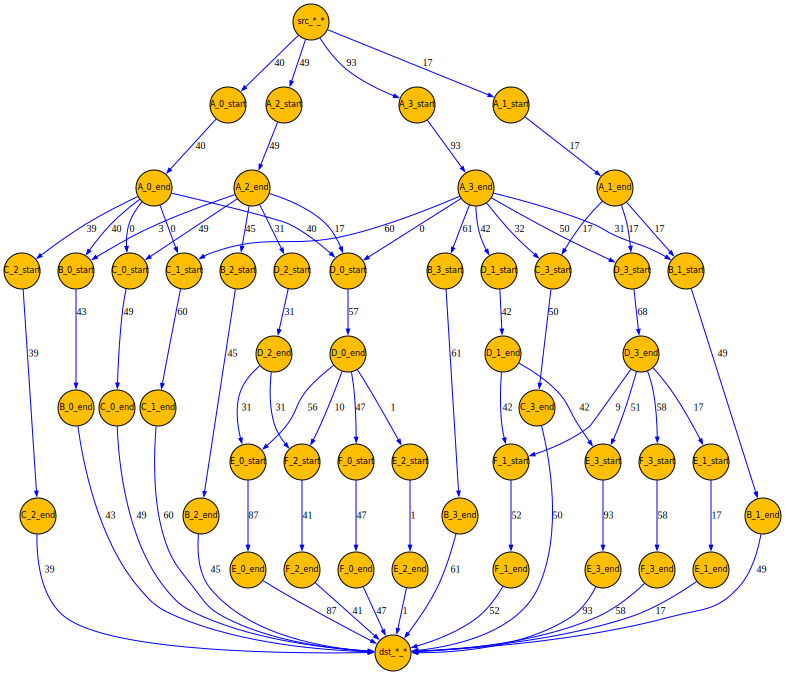

In [40]:
g_ = graphviz.Digraph()
# The node() method takes a name identifier as first argument and an optional label.
# The edge() method takes the names of start node and end node
# g_.size ="3,3"
print_all = True
node_pw = "1"
edge_pw = "1"
fs = "8"
edge_fs_0 = "10"
edge_fs_1 = "5"
fn="times bold italic"
edge_arrowsize="0.5"
edge_minlen="1"

if print_all:
    for k, v in aggregated_rps.items():
        if k[0] in request_flow["From"].to_list() and k[1] in request_flow["To"].to_list():
            node_color = "#FFBF00"
            g_.node(name=k[0], label=k[0], shape='circle', style='filled', fillcolor=node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.5")
            g_.node(name=k[1], label=k[1], shape='circle', style='filled', fillcolor=node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.5")
        temp = request_flow[request_flow["From"]==k[0]]
        temp = temp[temp["To"]==k[1]]
        if len(temp) > 0:
            # g_.edge(k[0], k[1], label=str(round(temp["Flow"].to_list()[0]), 2), penwidth=edge_pw, style="filled", fontsize=edge_fs_0, color="blue", arrowsize=edge_arrowsize, minlen=edge_minlen)
            g_.edge(k[0], k[1], label=str(int(temp["Flow"].to_list()[0])), penwidth=edge_pw, style="filled", fontsize=edge_fs_0, color="blue", arrowsize=edge_arrowsize, minlen=edge_minlen)
else:
    for k, v in aggregated_rps.items():
        if k[0] in request_flow["From"].to_list() and k[1] in request_flow["To"].to_list():
            node_color = "#FFBF00"
        else:
            node_color = "#A7A4A4"
        g_.node(name=k[0], label=k[0], shape='circle', style='filled', fillcolor=node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.75")
        g_.node(name=k[1], label=k[1], shape='circle', style='filled', fillcolor=node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True")
        temp = request_flow[request_flow["From"]==k[0]]
        temp = temp[temp["To"]==k[1]]
        if len(temp) > 0:
            # g_.edge(k[0], k[1], label=str(v)+", "+str(temp["Flow"].to_list()[0]), penwidth=edge_pw, style="filled", fontsize=edge_fs_0, color="blue", arrowsize=edge_arrowsize, minlen=edge_minlen)
            g_.edge(k[0], k[1], label=str(temp["Flow"].to_list()[0]), penwidth=edge_pw, style="filled", fontsize=edge_fs_0, color="blue", arrowsize=edge_arrowsize, minlen=edge_minlen)
        else:
            g_.edge(k[0], k[1], label=str(v), penwidth=edge_pw, style="dotted", fontsize=edge_fs_1, arrowhead="none", minlen=edge_minlen)
g_